In [1]:
import pandas as pd
from sqlalchemy import create_engine, Column, String, Float, Integer, Date, ForeignKey
from sqlalchemy.orm import sessionmaker, declarative_base, relationship

In [2]:
DATABASE_URL = "sqlite:///weather_data.db"
Base = declarative_base()
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
class Station(Base):
    __tablename__ = 'stations'

    id = Column(String, primary_key=True)
    name = Column(String)
    country = Column(String)
    region = Column(String, nullable=True)
    city = Column(String, nullable=True)
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)
    timezone = Column(String)
    daily_start = Column(Date)
    daily_end = Column(Date)
    monthly_start = Column(Date)
    monthly_end = Column(Date)

    weather_data = relationship("Weather", back_populates="station")

class Weather(Base):
    __tablename__ = 'weather'

    id = Column(Integer, primary_key=True, autoincrement=True)
    station_id = Column(String, ForeignKey('stations.id'))
    date = Column(Date)
    temperature_avg = Column(Float, nullable=True)
    temperature_min = Column(Float, nullable=True)
    temperature_max = Column(Float, nullable=True)
    precipitation = Column(Float, nullable=True)
    wind_speed = Column(Float, nullable=True)
    pressure = Column(Float, nullable=True)
    sunshine = Column(Float, nullable=True)

    station = relationship("Station", back_populates="weather_data")

In [5]:
query = session.query(
    Weather.date,
    Weather.temperature_avg,
    Weather.temperature_min,
    Weather.temperature_max,
    Weather.precipitation,
    Weather.wind_speed,
    Weather.pressure,
    Weather.sunshine,
    Station.id.label('station_id'),
    Station.name.label('station_name'),
    Station.region,
    Station.city
).join(Station, Weather.station_id == Station.id)

In [6]:
df = pd.read_sql(query.statement, session.bind)

df = df.astype({
    'date': 'datetime64[ns]',
    'temperature_avg': 'float64',
    'temperature_min': 'float64',
    'temperature_max': 'float64',
    'precipitation': 'float64',
    'wind_speed': 'float64',
    'pressure': 'float64',
    'sunshine': 'float64',
    'station_id': 'object',
    'station_name': 'object',
    'region': 'object',
    'city': 'object'
})

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [11]:
print("Dataset Shape:", df.shape)

Dataset Shape: (814990, 12)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814990 entries, 0 to 814989
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             814990 non-null  datetime64[ns]
 1   temperature_avg  589388 non-null  float64       
 2   temperature_min  458380 non-null  float64       
 3   temperature_max  453644 non-null  float64       
 4   precipitation    745007 non-null  float64       
 5   wind_speed       6007 non-null    float64       
 6   pressure         80890 non-null   float64       
 7   sunshine         47431 non-null   float64       
 8   station_id       814990 non-null  object        
 9   station_name     814990 non-null  object        
 10  region           814990 non-null  object        
 11  city             525550 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 74.6+ MB


In [13]:
df.head()

,date,temperature_avg,temperature_min,temperature_max,precipitation,wind_speed,pressure,sunshine,station_id,station_name,region,city
0,1958-01-01,-21.1,NaN,NaN,NaN,NaN,1010.0,NaN,20046,Polargmo Im. E. T. Krenkelja,ARK,None
1,1958-02-01,-25.4,NaN,NaN,NaN,NaN,1019.0,NaN,20046,Polargmo Im. E. T. Krenkelja,ARK,None
2,1958-03-01,-27.4,NaN,NaN,NaN,NaN,1023.0,NaN,20046,Polargmo Im. E. T. Krenkelja,ARK,None
3,1958-04-01,-19.9,NaN,NaN,NaN,NaN,1018.0,NaN,20046,Polargmo Im. E. T. Krenkelja,ARK,None
4,1958-05-01,-9.5,NaN,NaN,NaN,NaN,1022.0,NaN,20046,Polargmo Im. E. T. Krenkelja,ARK,None


### 1. Missing Data Analysis

In [14]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

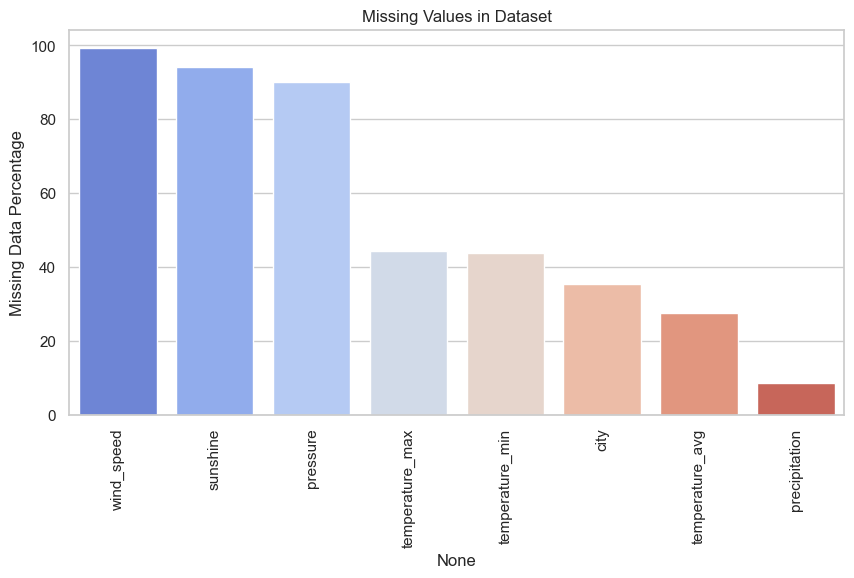

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_df.index, hue=missing_df.index, y=missing_df['Percentage'], palette="coolwarm", legend=False)
plt.xticks(rotation=90)
plt.ylabel("Missing Data Percentage")
plt.title("Missing Values in Dataset")
plt.show()

### 2. Summary Statistics

In [18]:
df.describe()

,date,temperature_avg,temperature_min,temperature_max,precipitation,wind_speed,pressure,sunshine
count,814990,589388.000000,458380.000000,453644.000000,745007.000000,6007.000000,80890.000000,47431.000000
mean,1975-07-10 10:47:19.661836352,-0.644227,-5.645024,4.666223,40.924429,11.800416,1015.281258,9240.890557
min,1820-05-01 00:00:00,-56.700000,-60.500000,-53.200000,0.000000,0.500000,985.700000,0.000000
25%,1957-10-01 00:00:00,-11.000000,-16.000000,-6.200000,14.100000,9.000000,1010.000000,4020.000000
50%,1977-12-01 00:00:00,1.000000,-2.700000,5.800000,30.200000,11.500000,1014.100000,9000.000000
75%,1995-02-01 00:00:00,11.600000,6.400000,17.600000,55.700000,14.200000,1019.700000,13980.000000
max,2022-01-01 00:00:00,32.200000,26.100000,54.000000,714.300000,37.900000,1059.000000,42660.000000
std,NaN,14.577440,14.657245,15.118755,38.755555,4.289304,7.648647,6082.105757


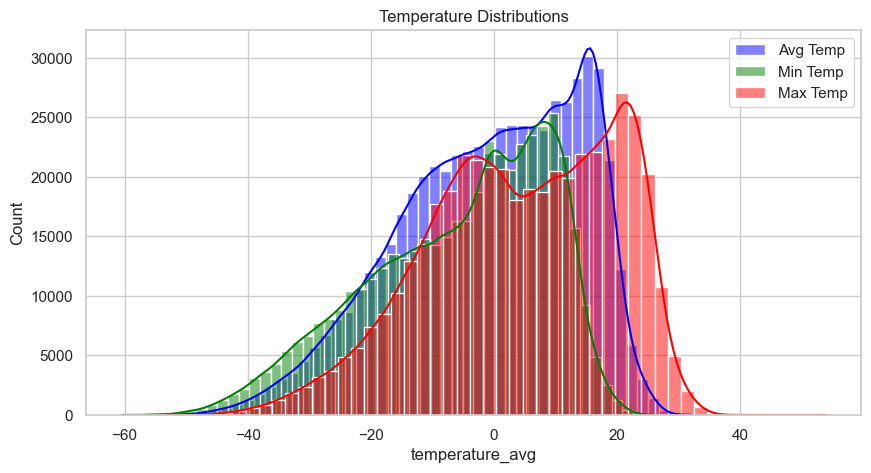

In [19]:
# Temperature distributions
plt.figure(figsize=(10, 5))
sns.histplot(df['temperature_avg'], bins=50, kde=True, color='blue', label='Avg Temp')
sns.histplot(df['temperature_min'], bins=50, kde=True, color='green', label='Min Temp', alpha=0.5)
sns.histplot(df['temperature_max'], bins=50, kde=True, color='red', label='Max Temp', alpha=0.5)
plt.legend()
plt.title("Temperature Distributions")
plt.show()

### 3. Time-Series Trends

In [20]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

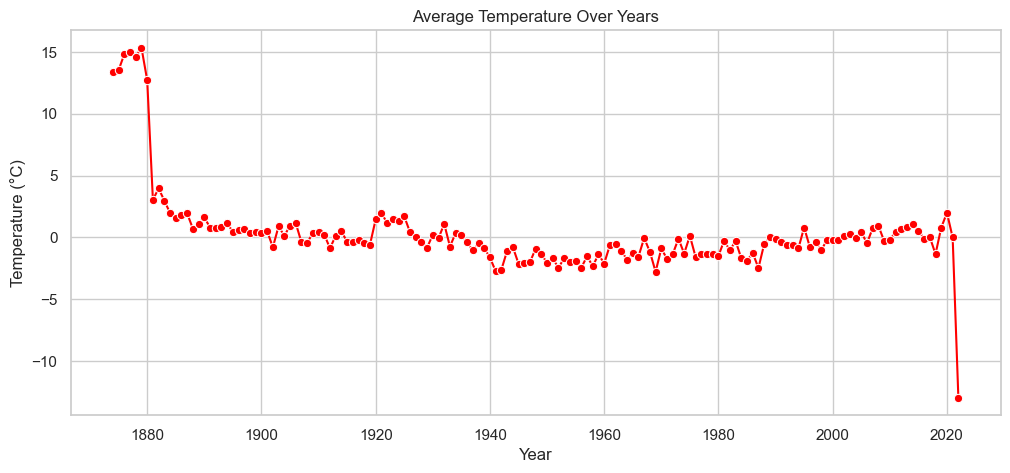

In [21]:
# Average temperature over years
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.groupby('year')['temperature_avg'].mean(), marker="o", color="red")
plt.title("Average Temperature Over Years")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

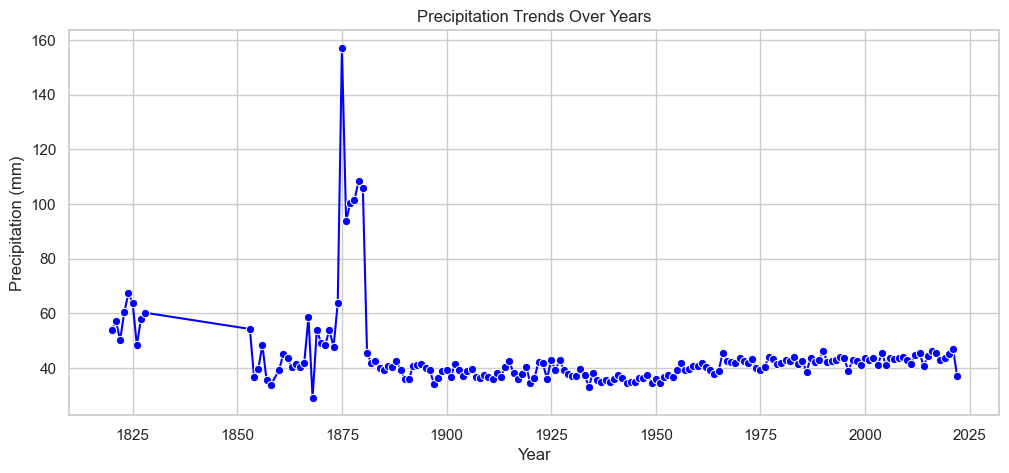

In [22]:
# Precipitation over years
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.groupby('year')['precipitation'].mean(), marker="o", color="blue")
plt.title("Precipitation Trends Over Years")
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
plt.show()

### 4. Regional Weather Analysis

In [24]:
top_cities = df['city'].value_counts().head(10).index
top_cities

Index(['Пермь', 'Москва', 'Солнечный', 'Нижний Новгород', 'Санкт-Петербург',
       'Иркутск', 'Октябрьский Городок', 'Земетчино', 'Сочи', 'Томск'],
      dtype='object', name='city')

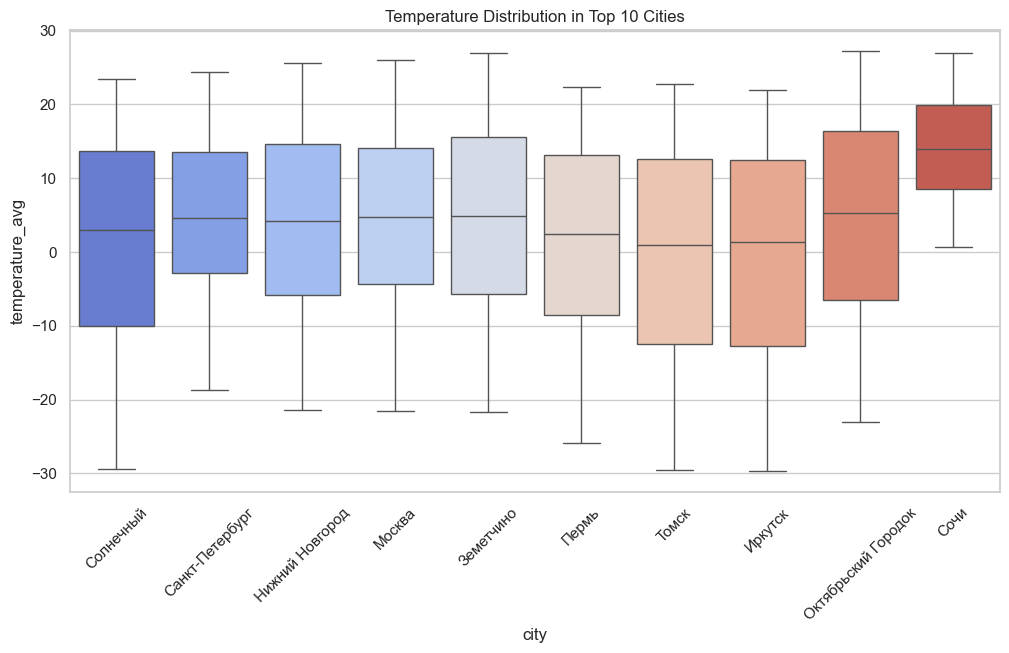

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['city'].isin(top_cities)], x='city', hue='city', y='temperature_avg', palette="coolwarm", legend=False)
plt.xticks(rotation=45)
plt.title("Temperature Distribution in Top 10 Cities")
plt.show()

### 5. Correlation Heatmap

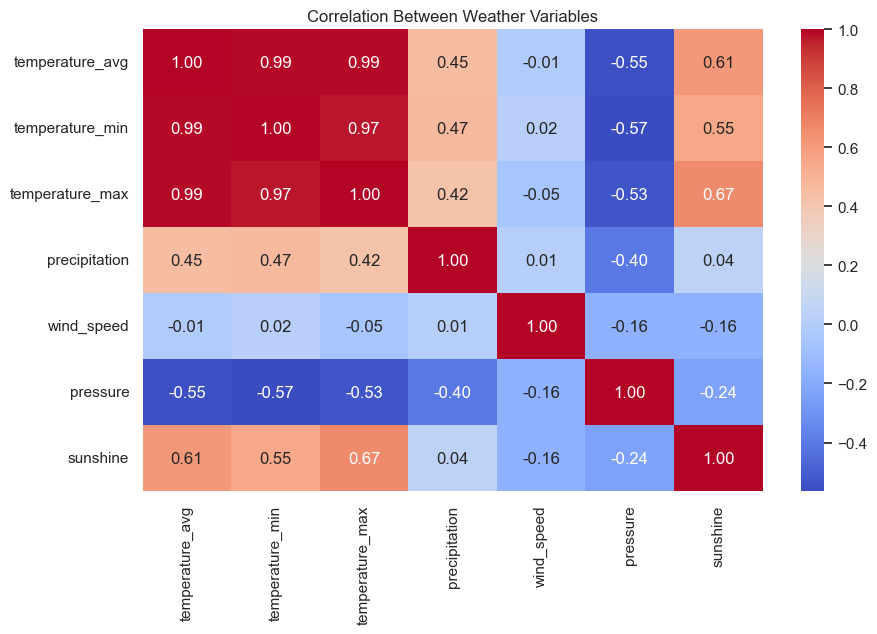

In [26]:
plt.figure(figsize=(10, 6))
corr = df[['temperature_avg', 'temperature_min', 'temperature_max', 'precipitation', 'wind_speed', 'pressure', 'sunshine']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Weather Variables")
plt.show()

### 6. Temperature Range

In [27]:
df['temp_range'] = df['temperature_max'] - df['temperature_min']

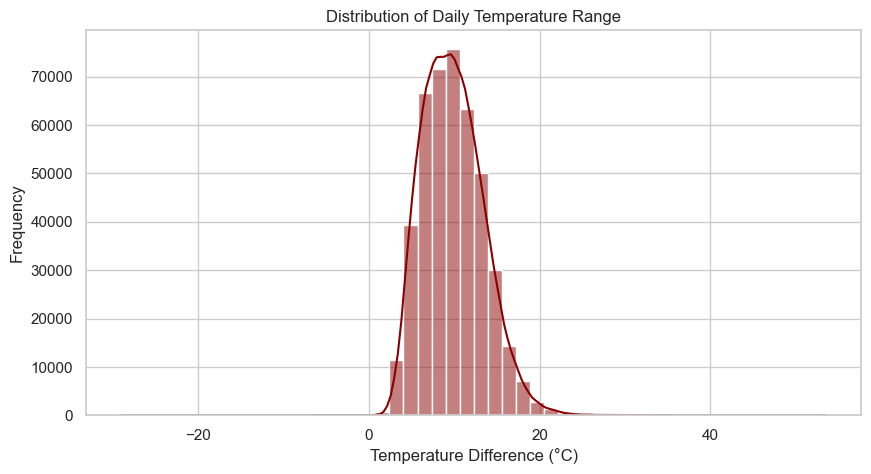

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(df['temp_range'].dropna(), bins=50, kde=True, color='darkred')
plt.title("Distribution of Daily Temperature Range")
plt.xlabel("Temperature Difference (°C)")
plt.ylabel("Frequency")
plt.show()

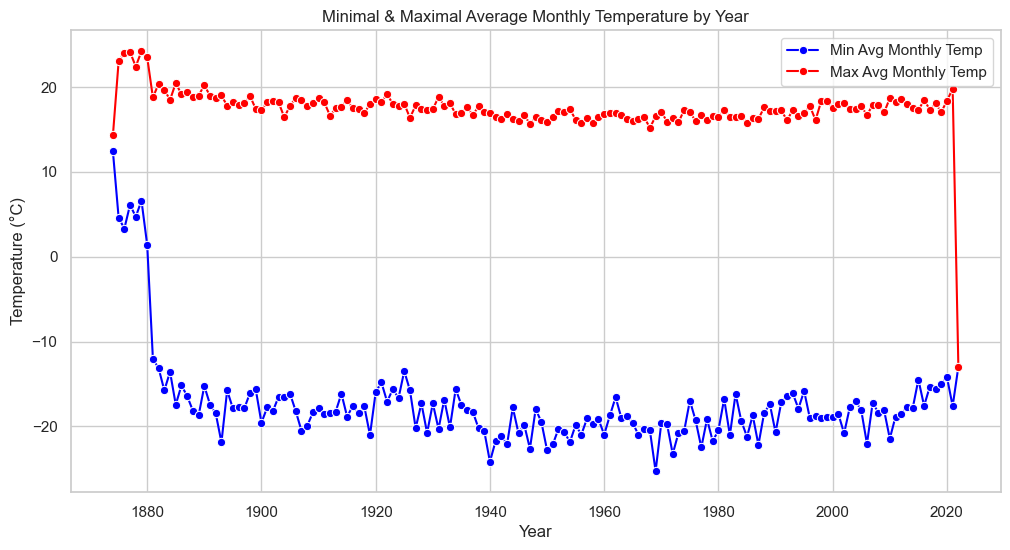

In [30]:
df_cp = df.dropna(subset=['month', 'temperature_avg'])

monthly_avg_temp = df_cp.groupby(['year', 'month'])['temperature_avg'].mean().reset_index()

min_avg_temp_per_year = monthly_avg_temp.loc[monthly_avg_temp.groupby('year')['temperature_avg'].idxmin()]
max_avg_temp_per_year = monthly_avg_temp.loc[monthly_avg_temp.groupby('year')['temperature_avg'].idxmax()]

plt.figure(figsize=(12, 6))
sns.lineplot(data=min_avg_temp_per_year, x='year', y='temperature_avg', marker='o', label="Min Avg Monthly Temp", color='blue')
sns.lineplot(data=max_avg_temp_per_year, x='year', y='temperature_avg', marker='o', label="Max Avg Monthly Temp", color='red')

plt.title("Minimal & Maximal Average Monthly Temperature by Year")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

### 7. Temperature Trends Over Time

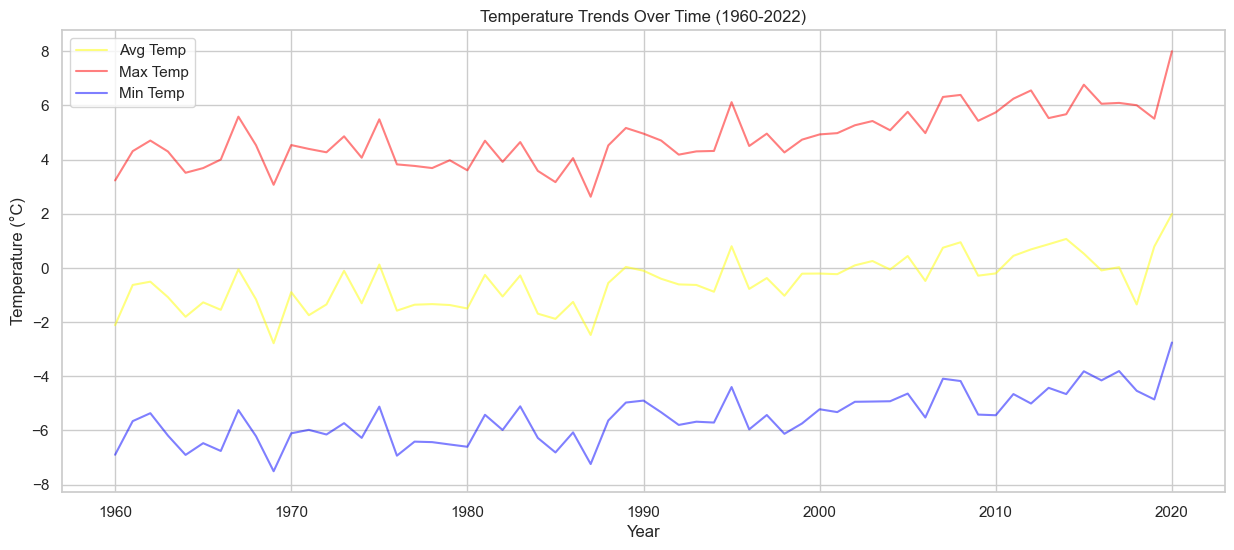

In [41]:
df_filtered = df[(df['date'].dt.year >= 1960) & (df['date'].dt.year <= 2020)]

plt.figure(figsize=(15, 6))
sns.lineplot(data=df_filtered.groupby('year')['temperature_avg'].mean(), errorbar=None, alpha=0.5, label="Avg Temp", color='yellow')
sns.lineplot(data=df_filtered.groupby('year')['temperature_max'].mean(), errorbar=None, alpha=0.5, label="Max Temp", color='red')
sns.lineplot(data=df_filtered.groupby('year')['temperature_min'].mean(), errorbar=None, alpha=0.5, label="Min Temp", color='blue')
plt.title("Temperature Trends Over Time (1960-2022)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

### 8. Monthly Temperature Trends

In [35]:
import warnings
warnings.filterwarnings("ignore")

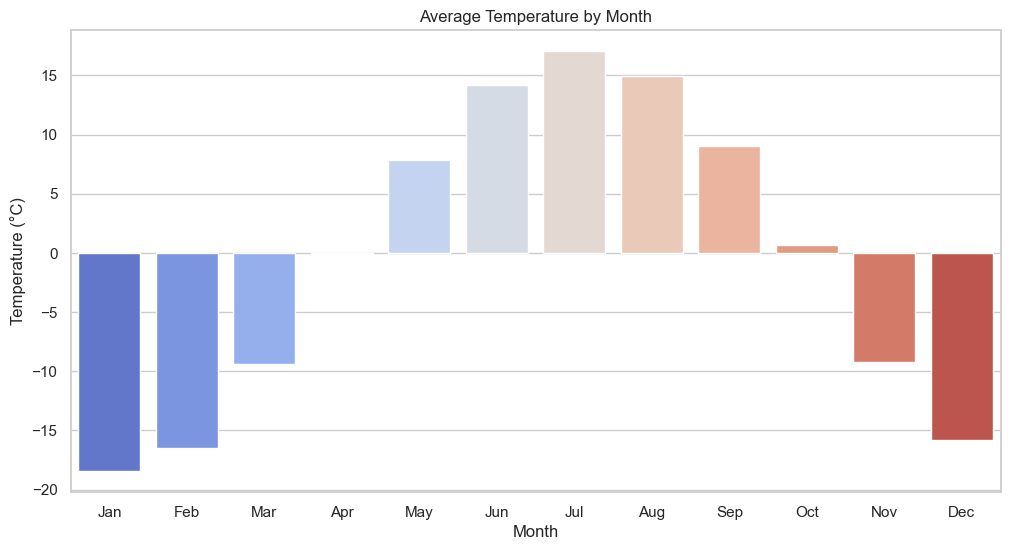

In [36]:
monthly_avg_temp = df.groupby('month')['temperature_avg'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_avg_temp, x='month', y='temperature_avg', palette="coolwarm")
plt.title("Average Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

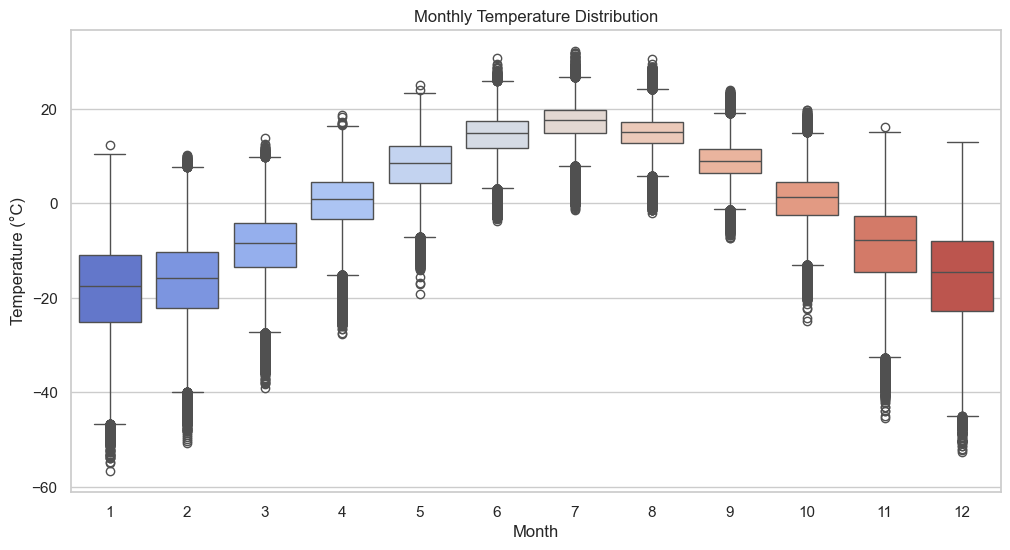

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='temperature_avg', palette="coolwarm")
plt.title("Monthly Temperature Distribution")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.show()

### 9. Heatmap of Missing Data

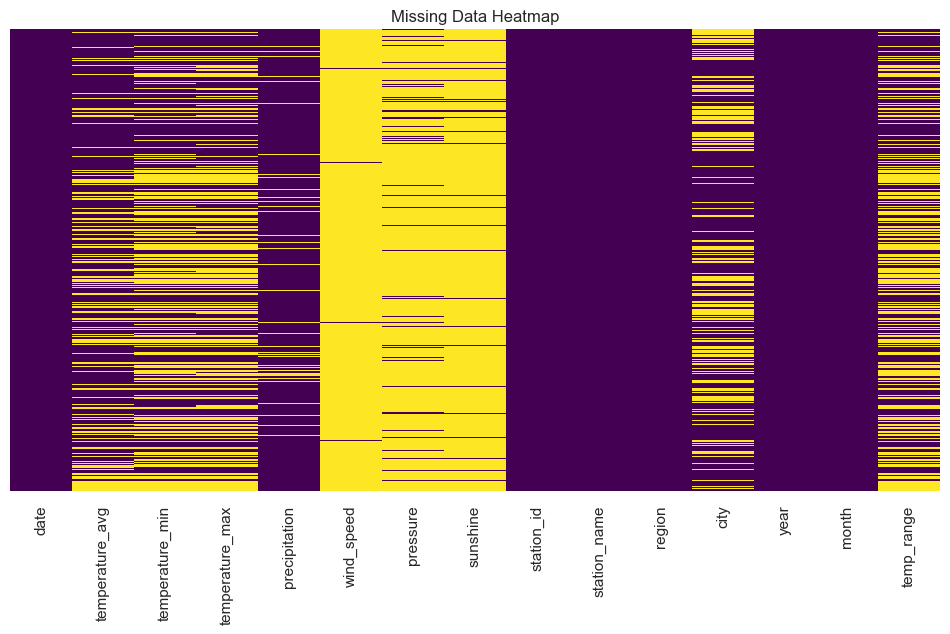

In [38]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()